In [1]:
import pickle
import pandas as pd
import numpy as np
import functions
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec, Phrases
from gensim.parsing.preprocessing import STOPWORDS as stop_words
from gensim.utils import simple_preprocess
from sklearn.feature_extraction import text
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer
# define function to perform one-hot encoding (a column flag for each genre) and pivot data
def create_genre_flags(df, col_list, id_vars=['movieId']):
    print('Encoding the following genres: '+', '.join(col_list))
    output=df.copy()
    for each in col_list:
        output[each]=output.genres_raw.apply(lambda x: 1 if each in x else 0)
    return output

my_stop_words = text.ENGLISH_STOP_WORDS

### Without genres within text

In [89]:
movieData=pd.read_csv('../My Tableau Repository/Data sources/Movies/movie_fact.csv',usecols=['movieId', 'description', 'genres_raw', 'release_year'])
movieData['description_genre']=movieData.description+movieData.genres_raw
movieData=movieData.rename(columns={'movieId':'id'})
movieData.id=movieData.id.apply(lambda x: 'M_'+str(x))
movieData.description_genre=movieData.description_genre.astype(str)
movieData.description=movieData.description.astype(str)


# create one-hot flag per genre and pivot the data (wide to long)
genres=list(set(np.concatenate(movieData.genres_raw.str.split(', '))))

movieData=create_genre_flags(movieData, genres)

movieData.info()

Encoding the following genres: Western, Crime, (no genres listed), Sci-Fi, Comedy, Fantasy, Animation, Romance, Drama, Children, Adventure, Film-Noir, Documentary, War, Horror, Action, Mystery, Thriller, Musical, IMAX
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   release_year        9742 non-null   int64 
 1   genres_raw          9742 non-null   object
 2   description         9742 non-null   object
 3   id                  9742 non-null   object
 4   description_genre   9742 non-null   object
 5   Western             9742 non-null   int64 
 6   Crime               9742 non-null   int64 
 7   (no genres listed)  9742 non-null   int64 
 8   Sci-Fi              9742 non-null   int64 
 9   Comedy              9742 non-null   int64 
 10  Fantasy             9742 non-null   int64 
 11  Animation           9742 non-null   int64 
 12

In [3]:
my_stop_words = text.ENGLISH_STOP_WORDS
# initiate a lancaster stemmer, and stem beer reviews while tagging them for Doc2Vec
ls = LancasterStemmer()
tagged_stem_docs = functions.stem_tag_docs(movieData[['id', 'description']].rename(columns={'description':'text'}), my_stop_words)
# Instantiate a Doc2Vec model, and build the vocab from the tagged documents

model = Doc2Vec(dm=0, dbow_words=1, min_count=4)

model.build_vocab(tagged_stem_docs, progress_per = 100)
model.train(tagged_stem_docs, total_examples=model.corpus_count, epochs=10)

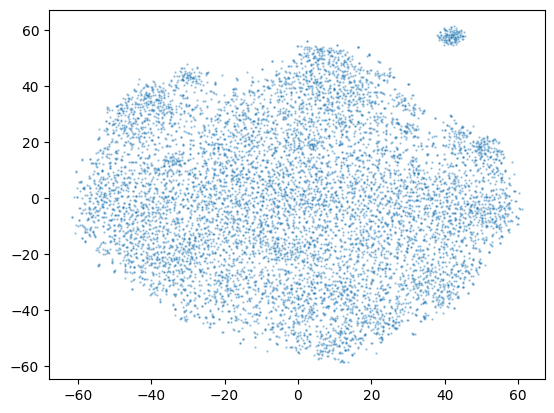

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
doc_tags = list(model.dv.key_to_index.keys())
X = model[doc_tags]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y']).reset_index()
plt.scatter(df['x'], df['y'], s=0.4, alpha=0.4)

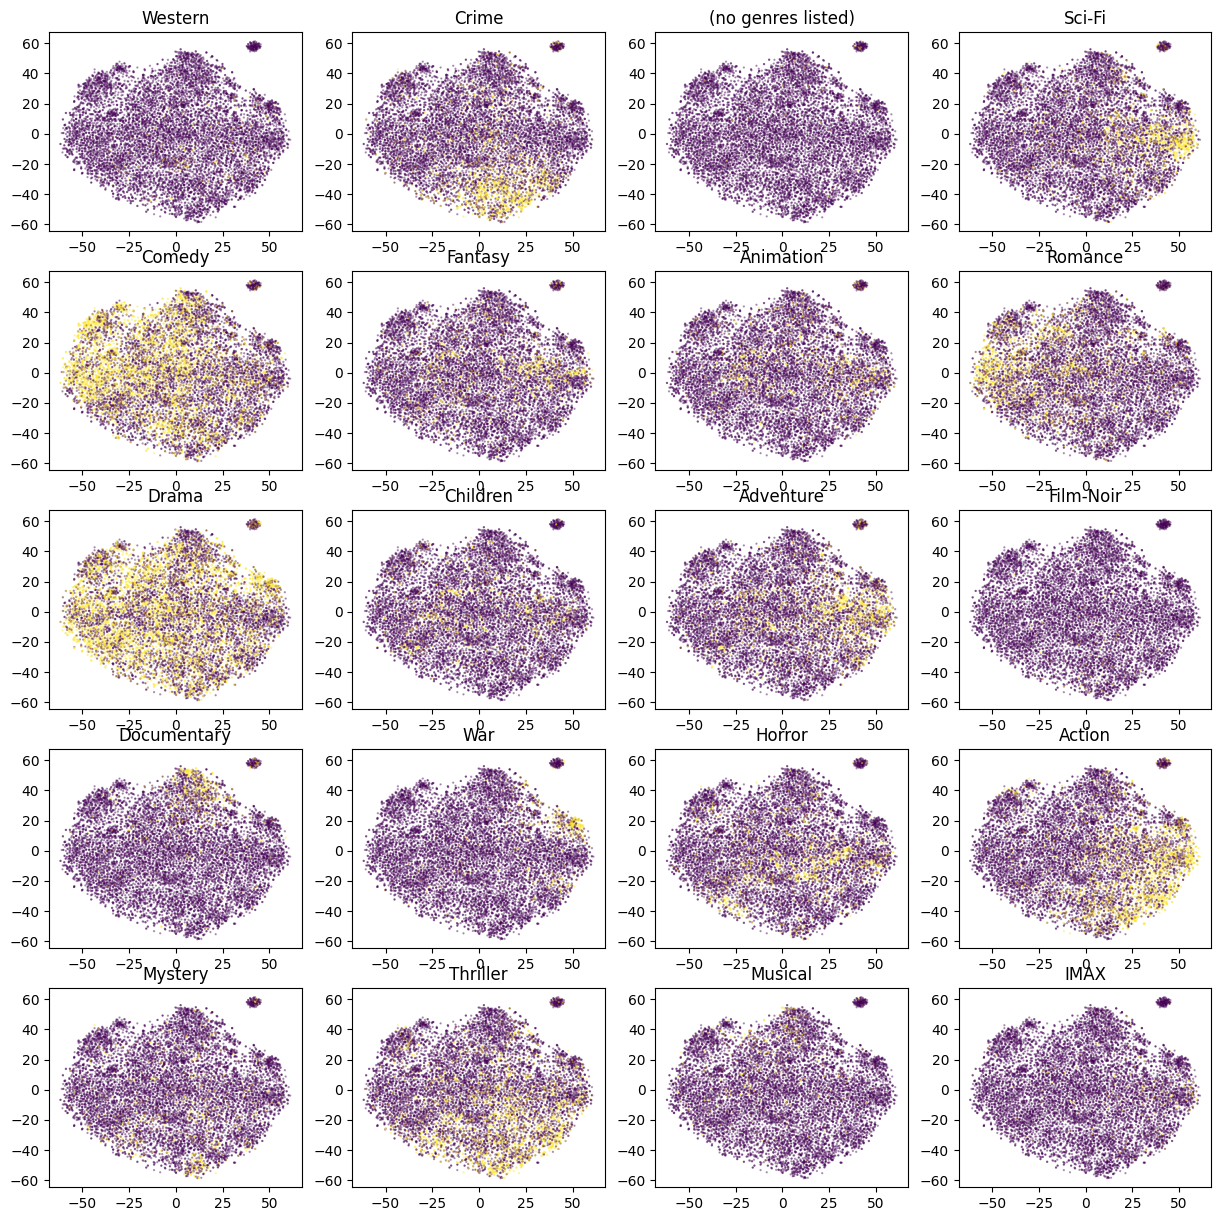

In [6]:
fig, ax=plt.subplots(5, 4, figsize=(15, 15))
row=0
col=0

for i in range(len(genres)):
    genre=genres[i]

    ax[row,col].scatter(df['x'], df['y'], c=movieData[genre], s=0.4, alpha=0.4)
    ax[row,col].set_title(genre)
    i+=1
    
    if i%4==0:
        row+=1
    col=i%4


### With Genre labels in text

In [7]:

tagged_stem_docs_genre = functions.stem_tag_docs(movieData[['id', 'description_genre']].rename(columns={'description_genre':'text'}), my_stop_words)
# Instantiate a Doc2Vec model, and build the vocab from the tagged documents

model_genre = Doc2Vec(dm=0, dbow_words=1, min_count=4)

model_genre.build_vocab(tagged_stem_docs_genre, progress_per = 100)
model_genre.train(tagged_stem_docs_genre, total_examples=model_genre.corpus_count, epochs=10)

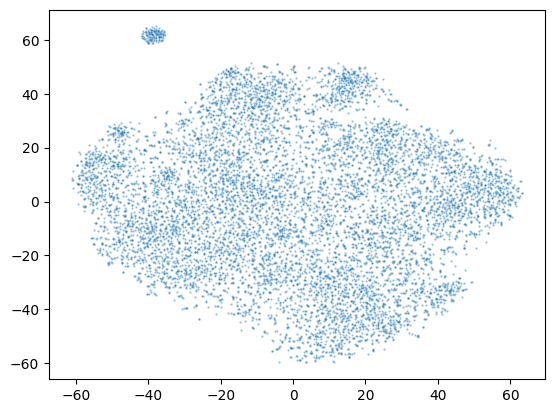

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
doc_tags = list(model_genre.dv.key_to_index.keys())
X_genre = model_genre[doc_tags]
tsne_genre = TSNE(n_components=2)
X_tsne_genre = tsne_genre.fit_transform(X_genre)
df_genre = pd.DataFrame(X_tsne_genre, index=doc_tags,columns=['tsne_x', 'tsne_y']).reset_index()
plt.scatter(df_genre['tsne_x'], df_genre['tsne_y'], s=0.4, alpha=0.4)

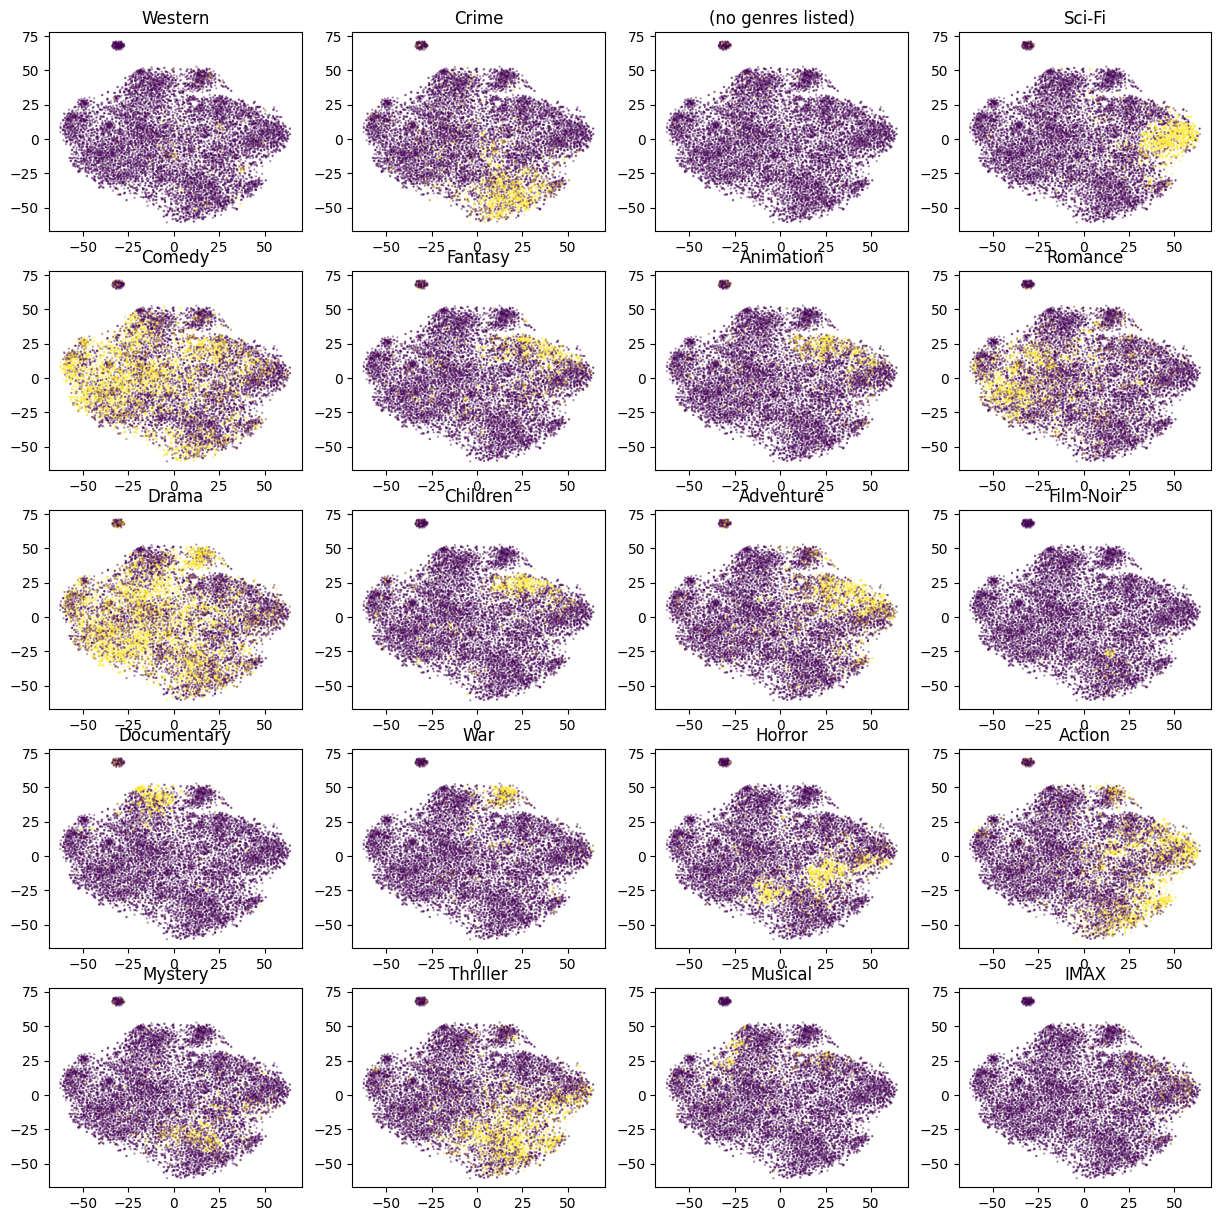

In [9]:
fig, ax=plt.subplots(5, 4, figsize=(15, 15))
row=0
col=0

for i in range(len(genres)):
    genre=genres[i]

    ax[row,col].scatter(df_genre['tsne_x'], df_genre['tsne_y'], c=movieData[genre], s=0.4, alpha=0.4)
    ax[row,col].set_title(genre)
    i+=1
    
    if i%4==0:
        row+=1
    col=i%4


In [95]:
def categorise_attribute(variable, genres):
    if variable in ['tsne_x', 'tsne_y']:
        return 'tsne_doc2vec'
    elif variable in genres:
        return 'genre'
    elif isinstance(variable, str):
        return 'other'
    elif isinstance(variable, int):
        return 'doc2vec'
    

d2v_df_genre=pd.concat([movieData.drop(columns=['genres_raw', 'description', 'description_genre']), pd.DataFrame(X_genre), pd.DataFrame(df_genre[['tsne_x', 'tsne_y']])], axis=1)
d2v_df_genre=pd.melt(d2v_df_genre, id_vars=['id'])
d2v_df_genre['attribute_type']= d2v_df_genre.variable.apply(lambda x: categorise_attribute(x, genres))
d2v_df_genre.head()

id      variable   value attribute_type
0  M_1  release_year  1995.0          other
1  M_2  release_year  1995.0          other
2  M_3  release_year  1995.0          other
3  M_4  release_year  1995.0          other
4  M_5  release_year  1995.0          other

In [91]:
d2v_df_genre.shape

(1198266, 4)

In [96]:
d2v_df_genre.to_csv('../My Tableau Repository/Data sources/Movies/movie_pivot_doc2vec_genre.csv', index=False)

In [93]:
moviefact=pd.read_csv('../My Tableau Repository/Data sources/Movies/movie_fact.csv')
moviefact=moviefact.rename(columns={'movieId':'id'})
moviefact.id=moviefact.id.apply(lambda x: 'M_'+str(x))
moviefact.to_csv('../My Tableau Repository/Data sources/Movies/movie_fact.csv', index=False)